# Playground

In [11]:
import copy
import itertools

import numpy as np

In [12]:
def create_state_space_for_two_servers(queue_capacity):
    """
    Create a state space for a given queue capacity.
    """
    return tuple(itertools.product(range(queue_capacity + 1), range(2), range(2)))

In [13]:
def calculate_costs_for_all_states(
    V2, state_space, queue_capacity, arrival_rate, service_rate_1, service_rate_2
):
    """
    Calculate the costs for all states.
    """
    V = np.zeros((queue_capacity + 1, 2, 2))
    gamma = arrival_rate + service_rate_1 + service_rate_2

    for s0, s1, s2 in state_space:
        V[s0, s1, s2] = (
            s0
            + s1
            + s2
            + (arrival_rate / gamma) * V2[min(queue_capacity, s0 + 1), s1, s2]
            + (service_rate_1 / gamma) * V2[s0, max(0, s1 - 1), s2]
            + (service_rate_2 / gamma) * V2[s0, s1, max(0, s2 - 1)]
        )
    return V

In [14]:
def update_temp_costs_for_state(state, V, V2):
    """
    Get the temporary costs for a given state.
    """
    s0, s1, s2 = state
    if s0 > 0 and s1 == 0 and s2 == 0:
        V2[s0, s1, s2] = min(
            V[s0, s1, s2], V[s0 - 1, s1 + 1, s2], V[s0 - 1, s1, s2 + 1]
        )
    if s0 > 0 and s1 == 0 and s2 == 1:
        V2[s0, s1, s2] = min(V[s0, s1, s2], V[s0 - 1, s1 + 1, s2])
    if s0 > 0 and s1 == 1 and s2 == 0:
        V2[s0, s1, s2] = min(V[s0, s1, s2], V[s0 - 1, s1, s2 + 1])
    return V2

In [15]:
def run_reinforcement_learning(
    arrival_rate, service_rate_1, service_rate_2, queue_capacity, iterations=100,
):
    """
    Run the reinforcement learning algorithm.
    """
    state_space = create_state_space_for_two_servers(
        queue_capacity=queue_capacity
    )
    costs_array = np.zeros((queue_capacity + 1, 2, 2))
    gamma = arrival_rate + service_rate_1 + service_rate_2

    for _ in range(iterations):
        
        temp_costs = costs_array.copy()
        for state in state_space:
            temp_costs = update_temp_costs_for_state(
                state=state, V=costs_array, V2=temp_costs
            )
        for state in state_space:
            costs_array = calculate_costs_for_all_states(
                V2=temp_costs, 
                state_space=state_space,
                queue_capacity=queue_capacity,
                arrival_rate=arrival_rate,
                service_rate_1=service_rate_1,
                service_rate_2=service_rate_2
            )
    return costs_array

In [16]:
def get_all_actions(V, queue_capacity):
    """
    Get all actions for a given state.
    """
    actions = {}
    for s0 in range(0, queue_capacity + 1):
        actions[(s0, 0, 0)] = np.argmin(([V[s0, 0, 0], V[s0 - 1, 1, 0], V[s0 - 1, 0, 1]]))
        actions[(s0, 0, 1)] = np.argmin(([V[s0, 0, 1], V[s0 - 1, 1, 1]]))
        actions[(s0, 1, 0)] = np.argmin(([V[s0, 1, 0], float("inf"), V[s0 - 1, 1, 1]]))
        actions[(s0, 1, 1)] = np.argmin(([V[s0, 1, 1]]))
    return actions

In [48]:
λ = 2
μ1 = 0.1
μ2 = 2
N = 20

In [49]:
costs = run_reinforcement_learning(
    arrival_rate=λ,
    service_rate_1=μ1,
    service_rate_2=μ2,
    queue_capacity=N,
    iterations=100
)

In [28]:
actions = get_all_actions(V=costs, queue_capacity=N)

In [29]:
for temp in range(25):
    print(temp,  "in queue ->", actions[temp, 0, 1])

0 in queue -> 0
1 in queue -> 0
2 in queue -> 0
3 in queue -> 0
4 in queue -> 0
5 in queue -> 1
6 in queue -> 1
7 in queue -> 1
8 in queue -> 1
9 in queue -> 1
10 in queue -> 1
11 in queue -> 1
12 in queue -> 1
13 in queue -> 1
14 in queue -> 1
15 in queue -> 1
16 in queue -> 1
17 in queue -> 1
18 in queue -> 1
19 in queue -> 1
20 in queue -> 1
21 in queue -> 1
22 in queue -> 1
23 in queue -> 1
24 in queue -> 1


In [54]:
def find_threshold(actions):
    """
    Find the threshold for a given se t of actions
    """
    for s0 in range(max(max(actions.keys()))):
        if actions[(s0, 0, 1)] == 1:
            return s0
    return np.nan

In [55]:
λ = 2
μ1 = 0.1
μ2 = 2
N = 20

In [72]:
mu_1_space = np.linspace(0.05, 0.1, 6)
mu_2_space = np.linspace(2, 3, 6)
λ = 2
N = 20

In [73]:
all_threshold = np.zeros((len(mu_1_space), len(mu_2_space)))
for (i, μ1) in enumerate(mu_1_space):
    for (j, μ2) in enumerate(mu_2_space):
        costs = run_reinforcement_learning(
            arrival_rate=λ,
            service_rate_1=μ1,
            service_rate_2=μ2,
            queue_capacity=N,
            iterations=100
        )
        actions = get_all_actions(V=costs, queue_capacity=N)
        threshold = find_threshold(actions)
        all_threshold[i, j] = threshold
        if np.isnan(threshold):
            print("NaN")
            break

NaN


In [75]:
for i, row in enumerate(all_threshold):
    for j, val in enumerate(row):
        if val == 0:
            all_threshold[i, j] = np.nan

In [76]:
all_threshold

array([[ 7.,  9., 10., 12., 14., nan],
       [ 7.,  8.,  9., 11., 13., 14.],
       [ 6.,  7.,  8., 10., 11., 13.],
       [ 6.,  7.,  8.,  9., 11., 12.],
       [ 5.,  6.,  7.,  8., 10., 11.],
       [ 5.,  6.,  7.,  8.,  9., 10.]])

In [67]:
import matplotlib.pyplot as plt

In [106]:
plt.get_xlim()

AttributeError: module 'matplotlib.pyplot' has no attribute 'get_xlim'

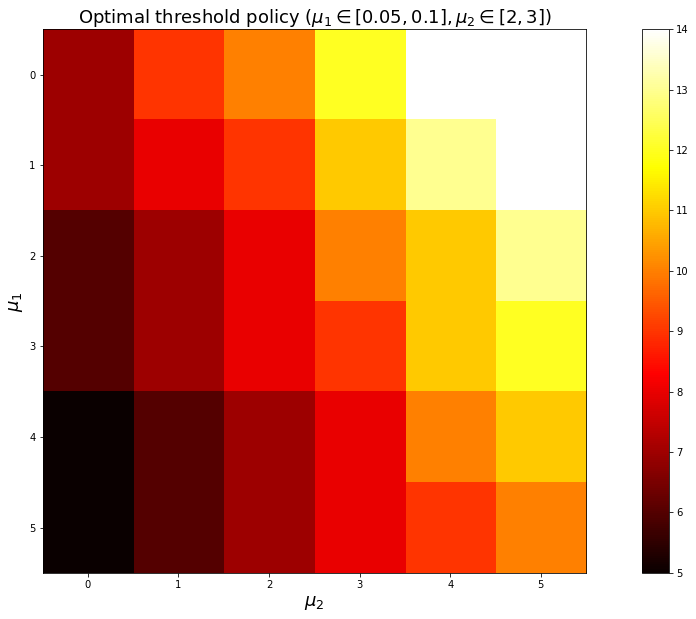

In [117]:


plt.figure(figsize=(20, 10))
plt.imshow(all_threshold, cmap='hot')
plt.colorbar()
plt.title("Optimal threshold policy $(μ_1 \in [0.05, 0.1], μ_2 \in [2, 3])$", fontsize=18)
plt.ylabel("$μ_1$ ", fontsize=18)
plt.xlabel("$μ_2$", fontsize=18);

In [101]:
mu_1_space, mu_2_space

(array([0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
 array([2. , 2.2, 2.4, 2.6, 2.8, 3. ]))

In [118]:
new_mu_1_space = np.linspace(0.05, 0.5, 20)
mu_2 = 2
λ = 2
N = 20

In [120]:
plot_thresholds = []
for (i, μ1) in enumerate(new_mu_1_space):
    costs = run_reinforcement_learning(
        arrival_rate=λ,
        service_rate_1=μ1,
        service_rate_2=μ2,
        queue_capacity=N,
        iterations=100
    )
    actions = get_all_actions(V=costs, queue_capacity=N)
    threshold = find_threshold(actions)
    plot_thresholds.append(threshold)

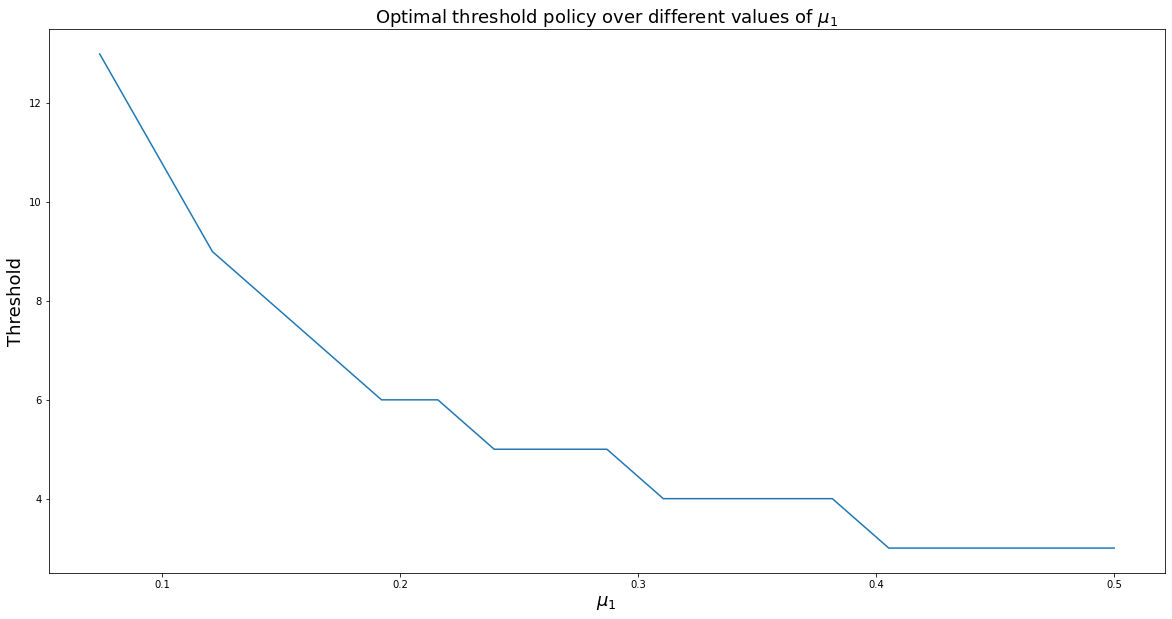

In [127]:
plt.figure(figsize=(20, 10))
plt.plot(new_mu_1_space, plot_thresholds)
plt.title("Optimal threshold policy over different values of $μ_1$", fontsize=18)
plt.xlabel("$μ_1$ ", fontsize=18)
plt.ylabel("Threshold", fontsize=18);

In [153]:
# queue with 2 servers at different speeds
la=2;mu1=0.1;mu2=2
N=20
V=array(0,dim=c(N+1,2,2))
gamma=la+mu1+mu2
for(iter in 1:1000)
{
  # decision
  V2=V
  for(x in 0:N)for(y1 in 0:1)for(y2 in 0:1)
  {
    if(x>0 && y1==0 && y2==0)V2[x+1,y1+1,y2+1]=
        min(V[x+1,y1+1,y2+1],V[x,y1+2,y2+1],V[x,y1+1,y2+2])
    if(x>0 && y1==0 && y2==1)V2[x+1,y1+1,y2+1]=
        min(V[x+1,y1+1,y2+1],V[x,y1+2,y2+1])
    if(x>0 && y1==1 && y2==0)V2[x+1,y1+1,y2+1]=
        min(V[x+1,y1+1,y2+1],V[x,y1+1,y2+2])
  }
  # costs & arrivals & departures
  for(x in 0:N)for(y1 in 0:1)for(y2 in 0:1)
    V[x+1,y1+1,y2+1]=x+y1+y2+
      la/gamma*V2[min(N+1,x+2),y1+1,y2+1]+
      mu1/gamma*V2[x+1,max(1,y1-1),y2+1]+
      mu2/gamma*V2[x+1,y1+1,max(1,y2-1)]
}
# optimal policy
# N=10;y1=0;y2=0
# for(x in 1:N)print(which.min(c(V[x+1,y1+1,y2+1],V[x,y1+2,y2+1],V[x,y1+1,y2+2])))
y1=0;y2=1
for(x in 0:10)print(which.min(c(V[x+1,y1+1,y2+1],V[x,y1+2,y2+1])))
y1=1;y2=0  
for(x in 1:N)print(which.min(c(V[x+1,y1+1,y2+1],V[x,y1+1,y2+2])))

## Old way

In [27]:
# Queue with 2 servers at different speeds
λ = 2
μ1 = 10
μ2 = 2

N = 10
V = np.zeros((N + 1, 2, 2))
gamma = λ + μ1 + μ2

for iter in range(100):
  V2 = copy.deepcopy(V)
  # decision
  for s0, s1, s2 in itertools.product(range(N + 1), range(2), range(2)):
    if s0 > 0 and s1 == 0 and s2 == 0:
      V2[s0, s1, s2] = min(
        V[s0, s1, s2], V[s0 - 1, s1 + 1, s2], V[s0 - 1, s1, s2 + 1]
      )
    if s0 > 0 and s1 == 0 and s2 == 1:
        V2[s0, s1, s2] = min(V[s0, s1, s2], V[s0 - 1, s1 + 1, s2])
    if s0 > 0 and s1 == 1 and s2 == 0:
        V2[s0, s1, s2] = min(V[s0, s1, s2], V[s0 - 1, s1, s2 + 1])

    # costs & arrivals & departures
    for s0, s1, s2 in itertools.product(range(N + 1), range(2), range(2)):
        V[s0, s1, s2] = (
            s0
            + s1
            + s2
            + (λ / gamma) * V2[min(N, s0 + 1), s1, s2]
            + (μ1 / gamma) * V2[s0, max(0, s1 - 1), s2]
            + (μ2 / gamma) * V2[s0, s1, max(0, s2 - 1)]
        )


## Actions:

- $s_0$ = Wait
- $s_1$ = Send to server 1
- $s_2$ = Send to server 2

In [28]:
# optimal policy
# Both servers are idle

actions = {}
for s0 in range(0, N + 1):
  actions[(s0, 0, 0)] = np.argmin(([V[s0, 0, 0], V[s0 - 1, 1, 0], V[s0 - 1, 0, 1]]))
  actions[(s0, 0, 1)] = np.argmin(([V[s0, 0, 1], V[s0 - 1, 1, 1]]))
  actions[(s0, 1, 0)] = np.argmin(([V[s0, 1, 0], float("inf"), V[s0 - 1, 1, 1]]))
  actions[(s0, 1, 1)] = np.argmin(([V[s0, 1, 1]]))

In [29]:
actions[3, 1, 0]

2

In [30]:
V

array([[[ 29.21745392,  36.21292412],
        [ 31.02044959,  37.97849774]],

       [[ 32.53768103,  39.52994009],
        [ 34.87030219,  41.82953467]],

       [[ 37.63017402,  44.62711956],
        [ 40.42066512,  47.4037399 ]],

       [[ 44.40407029,  51.43201447],
        [ 47.41883526,  54.62472549]],

       [[ 52.76495369,  59.84481686],
        [ 55.79893619,  63.24565624]],

       [[ 62.50629384,  69.65465843],
        [ 65.56460906,  73.26625796]],

       [[ 73.63198353,  80.86168759],
        [ 76.71847604,  84.68488556]],

       [[ 86.14459587,  93.46373634],
        [ 89.26097784,  97.49166838]],

       [[100.04303698, 107.44536377],
        [103.18259438, 111.62738254]],

       [[115.26229785, 122.71198923],
        [118.41652899, 126.73668474]],

       [[129.17412218, 136.65631866],
        [132.33485434, 140.6875152 ]]])

In [110]:
y1 = 0
y2 = 1

for x in range(1, N + 1):
  print(np.argmin(([V[x, y1, y2], V[x - 1, y1 + 1, y2]])))


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [111]:
y1 = 1
y2 = 0

for x in range(1, N + 1):
  print(np.argmin(([V[x, y1, y2], V[x - 1, y1, y2 + 1]])))


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [ ]:
# queue with 2 servers at different speeds
la=2;mu1=0.1;mu2=2
N=100
V=array(0,dim=c(N+1,2,2))
gamma=la+mu1+mu2
for(iter in 1:1000)
{
  # decision
  V2=V
  for(x in 0:N)for(y1 in 0:1)for(y2 in 0:1)
  {
    if(x>0 && y1==0 && y2==0)V2[x+1,y1+1,y2+1]=
        min(V[x+1,y1+1,y2+1],V[x,y1+2,y2+1],V[x,y1+1,y2+2])
    if(x>0 && y1==0 && y2==1)V2[x+1,y1+1,y2+1]=
        min(V[x+1,y1+1,y2+1],V[x,y1+2,y2+1])
    if(x>0 && y1==1 && y2==0)V2[x+1,y1+1,y2+1]=
        min(V[x+1,y1+1,y2+1],V[x,y1+1,y2+2])
  }
  # costs & arrivals & departures
  for(x in 0:N)for(y1 in 0:1)for(y2 in 0:1)
    V[x+1,y1+1,y2+1]=x+y1+y2+
      la/gamma*V2[min(N+1,x+2),y1+1,y2+1]+
      mu1/gamma*V2[x+1,max(1,y1-1),y2+1]+
      mu2/gamma*V2[x+1,y1+1,max(1,y2-1)]
}
# optimal policy
N=10;y1=0;y2=0
for(x in 1:N)print(which.min(c(V[x+1,y1+1,y2+1],V[x,y1+2,y2+1],V[x,y1+1,y2+2])))
y1=0;y2=1
for(x in 1:N)print(which.min(c(V[x+1,y1+1,y2+1],V[x,y1+2,y2+1])))
y1=1;y2=0  
for(x in 1:N)print(which.min(c(V[x+1,y1+1,y2+1],V[x,y1+1,y2+2])))
